## Import

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # nvidia-smi로 비어있는 gpu 확인하고 여기서 선택할것!

In [8]:
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from IPython.display import clear_output 
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utils

In [3]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        print("full dataset size : ",len(self.data))
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #img_path = self.data.iloc[idx, 1]    # default : ./train_img/TRAIN_0000.png
        img_path = "../data"+self.data.iloc[idx, 1][1:]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        # mask_rle = self.data.iloc[idx, 2]
        # mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        # if self.transform:
        #     augmented = self.transform(image=image, mask=mask)
        #     image = augmented['image']
        #     mask = augmented['mask']

        # return image, mask
        assert False , "SatelliteDataset class must be used as test dataset obj"

In [5]:
class TV_SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, is_train = True, TVcutter = int(7140 * 0.9)):
        self.is_train = is_train
        if self.is_train:
            self.data = pd.read_csv(csv_file)[:TVcutter]
        else:
            self.data = pd.read_csv(csv_file)[TVcutter:]
        self.transform = transform
        print("full dataset size : ",len(self.data))
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #img_path = self.data.iloc[idx, 1]    # default : ./train_img/TRAIN_0000.png
        img_path = "../data"+self.data.iloc[idx, 1][1:]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Data Loader

In [6]:
transform = A.Compose(
    [   
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

train_dataset = TV_SatelliteDataset(csv_file='../data/train.csv', transform=transform, is_train=True)
val_dataset = TV_SatelliteDataset(csv_file='../data/train.csv', transform=transform, is_train=False)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)

full dataset size :  6426
full dataset size :  714


<class 'torch.Tensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


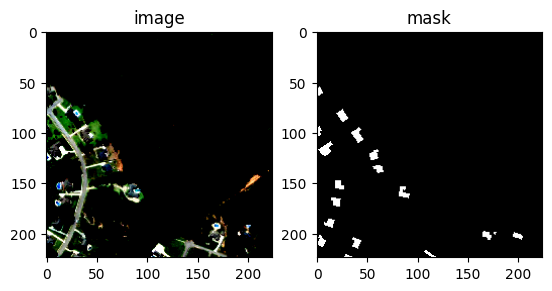

torch.Size([224, 224])
torch.Size([224, 224, 3])


In [13]:
def printdataset(dataset,idx = 0):
    clear_output()
    sample = dataset[idx]
    image, mask = sample
    print(type(image))
# 이미지와 마스크 시각화
    plt.subplot(1, 2, 1)
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    plt.title("image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("mask")
    plt.show()
    #print(len(image),len(image[0]), len(mask), len(mask[0]))
    print(mask.shape)
    print(image.shape)
    time.sleep(1)
    
for i in range(6400,6400+20):
    printdataset(train_dataset, i)

## Define Model

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=1, up_sample_mode='conv_transpose'): # out_class 1???
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

## Model Train

In [ ]:
dice_loss = smp.losses.DiceLoss(mode='binary')

In [8]:
# model 초기화
# model = UNet().to(device)

# backbone resnet
model = smp.Unet("resnet34" , encoder_weights="imagenet", activation=None, in_channels=3, classes=1)
for name, p in model.named_parameters():
    if "encoder" in name:
        p.requires_grad = False

model.to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# validation
best_validation_loss = 200.0

# training loop
for epoch in range(20):  # 10 에폭 동안 학습합니다.
    print(f'======Epoch {epoch+1} =======')
    model.train()
    epoch_loss = 0
    val_loss = 0
    for images, masks in tqdm(train_dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for images, masks in tqdm(val_dataloader):
            images = images.float().to(device)
            score_masks = masks.unsqueeze(1)
            masks = masks.float().to(device)
            outputs = model(images)
            #score
            score_masks = score_masks.to(device)
            tp, fp, fn, tn = smp.metrics.get_stats(outputs, score_masks, mode='binary', threshold=0.35)
            f1 = smp.metrics.f1_score(tp, fp, fn, tn)
            iou = smp.metrics.iou_score(tp, fp, fn, tn)
            accu = smp.metrics.accuracy(tp,fp, fn, tn)
            dice_score = 1 - dice_loss(outputs, score_masks)
            #loss
            loss = criterion(outputs, masks.unsqueeze(1))
            val_loss += loss.item()
    
    if best_validation_loss > val_loss/len(val_dataloader):
        best_validation_loss = val_loss/len(val_dataloader)
        torch.save(model, f'../best_model/best_model.pth')
        print('Model saved!')
    print(f'Epoch {epoch+1}, Train_Loss: {epoch_loss/len(train_dataloader)}, Val_Loss: {val_loss/len(val_dataloader)}')
    print(f'IoU Score : {torch.mean(iou)} f1 Score : {torch.mean(f1)} accuracy: {torch.mean(accu)}')
    print(f'Dice score : {dice_score}')

100%|██████████████████████████████████████████████████████████████| 45/45 [00:38<00:00,  1.17it/s]


Model saved!
Epoch 1, Train_Loss: 0.15242860479215484, Val_Loss: 0.10096130205525292


100%|██████████████████████████████████████████████████████████████| 45/45 [00:24<00:00,  1.81it/s]


Model saved!
Epoch 2, Train_Loss: 0.09289389022102404, Val_Loss: 0.088911249074671


100%|██████████████████████████████████████████████████████████████| 45/45 [00:24<00:00,  1.85it/s]


Model saved!
Epoch 3, Train_Loss: 0.08485155198630409, Val_Loss: 0.0829303373893102


100%|██████████████████████████████████████████████████████████████| 45/45 [00:26<00:00,  1.69it/s]


Model saved!
Epoch 4, Train_Loss: 0.08064309240721945, Val_Loss: 0.08050573145349821


100%|██████████████████████████████████████████████████████████████| 45/45 [00:29<00:00,  1.51it/s]


Model saved!
Epoch 5, Train_Loss: 0.0741867572254506, Val_Loss: 0.07610516879293654


100%|██████████████████████████████████████████████████████████████| 45/45 [00:28<00:00,  1.58it/s]


Epoch 6, Train_Loss: 0.07280728965997696, Val_Loss: 0.08061404724915823


100%|██████████████████████████████████████████████████████████████| 45/45 [00:27<00:00,  1.63it/s]


Model saved!
Epoch 7, Train_Loss: 0.06911750533502196, Val_Loss: 0.07332663854791058


100%|██████████████████████████████████████████████████████████████| 45/45 [00:33<00:00,  1.33it/s]


Epoch 8, Train_Loss: 0.06547789516585384, Val_Loss: 0.07404906377196312


100%|██████████████████████████████████████████████████████████████| 45/45 [00:30<00:00,  1.46it/s]


Epoch 9, Train_Loss: 0.0679265352345966, Val_Loss: 0.07867428412040074


100%|██████████████████████████████████████████████████████████████| 45/45 [00:28<00:00,  1.59it/s]


Model saved!
Epoch 10, Train_Loss: 0.06578206478511515, Val_Loss: 0.07324254347218408


100%|██████████████████████████████████████████████████████████████| 45/45 [00:30<00:00,  1.47it/s]


Epoch 11, Train_Loss: 0.06124717726450951, Val_Loss: 0.0751054909494188


100%|██████████████████████████████████████████████████████████████| 45/45 [00:38<00:00,  1.15it/s]


Model saved!
Epoch 12, Train_Loss: 0.05884362375410042, Val_Loss: 0.0708161645465427


100%|██████████████████████████████████████████████████████████████| 45/45 [00:24<00:00,  1.83it/s]


Model saved!
Epoch 13, Train_Loss: 0.0585502997522627, Val_Loss: 0.07047316796249814


100%|██████████████████████████████████████████████████████████████| 45/45 [00:26<00:00,  1.67it/s]


Epoch 14, Train_Loss: 0.05641866316879863, Val_Loss: 0.07132161284486453


100%|██████████████████████████████████████████████████████████████| 45/45 [00:26<00:00,  1.67it/s]


Epoch 15, Train_Loss: 0.05849266155108587, Val_Loss: 0.07099131693442663


100%|██████████████████████████████████████████████████████████████| 45/45 [00:27<00:00,  1.63it/s]


Model saved!
Epoch 16, Train_Loss: 0.05466677929131101, Val_Loss: 0.06795805676115883


100%|██████████████████████████████████████████████████████████████| 45/45 [00:29<00:00,  1.53it/s]


Epoch 17, Train_Loss: 0.05238524992111607, Val_Loss: 0.06852392761243714


100%|██████████████████████████████████████████████████████████████| 45/45 [00:25<00:00,  1.79it/s]


Epoch 18, Train_Loss: 0.05087199577348149, Val_Loss: 0.07134208753705025


100%|██████████████████████████████████████████████████████████████| 45/45 [00:25<00:00,  1.77it/s]


Epoch 19, Train_Loss: 0.04987688457584055, Val_Loss: 0.0705165925125281


100%|██████████████████████████████████████████████████████████████| 45/45 [00:15<00:00,  2.93it/s]

Epoch 20, Train_Loss: 0.049813762858547085, Val_Loss: 0.07014360485805406


In [10]:
model = torch.load('../best_model/best_model.pth')
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Inference

In [11]:
test_dataset = SatelliteDataset(csv_file='../data/test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

full dataset size :  60640


In [12]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        
        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35
        
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

100%|██████████████████████████████████████████████████████████| 3790/3790 [02:38<00:00, 23.86it/s]


## Submission

In [13]:
submit = pd.read_csv('../data/sample_submission.csv')
submit['mask_rle'] = result

In [14]:
submit.to_csv('../submit/submit_UNETbbresnet34imagenet_not_freezed.csv', index=False)